# Basic popgen with sgkit

In [1]:
%run setup.ipynb

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from dask.diagnostics import ProgressBar
import sgkit as sg
import xarray as xr

In [6]:
ds = xr.open_zarr(str(here() / 'data/sgkit/ag1000g_rechunked4.zarr'), concat_characters=False)
ds

<xarray.Dataset>
Dimensions:             (alleles: 4, ploidy: 2, samples: 1142, variants: 57837885)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    sample_id           (samples) <U1 dask.array<chunksize=(1142,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(65536, 4), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
Attributes:
    contigs:                    ['2L', '2R', '3L', '3R', 'X']
    max_variant_allele_length:  1

Count alleles and save to disk, since this is a computationally intensive step

In [7]:
ds = sg.count_call_alleles(ds)
with ProgressBar():
    ds.to_zarr(str(here() / 'data/sgkit/ag1000g_call_allele_count.zarr'))
ds

[########################################] | 100% Completed | 23min 38.5s


<xarray.Dataset>
Dimensions:             (alleles: 4, ploidy: 2, samples: 1142, variants: 57837885)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_allele_count   (variants, samples, alleles) uint8 dask.array<chunksize=(65536, 1142, 4), meta=np.ndarray>
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    sample_id           (samples) <U1 dask.array<chunksize=(1142,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(65536, 4), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>

Variant stats

In [5]:
with ProgressBar():
    vs = sg.variant_stats(ds, merge=False)
vs

[########################################] | 100% Completed | 11min 20.9s


<xarray.Dataset>
Dimensions:                   (alleles: 4, variants: 57837885)
Dimensions without coordinates: alleles, variants
Data variables:
    variant_n_called          (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_call_rate         (variants) float64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_n_het             (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_n_hom_ref         (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_n_hom_alt         (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_n_non_ref         (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_allele_count      (variants, alleles) uint64 2263 1 0 0 ... 727 0 0
    variant_allele_total      (variants) int64 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_allele_frequency  (variants, alleles) float64 dask.array<chunksize=(65536, 4), meta=np.ndarray>

In [25]:
vs.variant_n_called[:100].values

array([1132, 1141, 1140, 1141, 1141, 1141, 1141, 1139, 1142, 1141, 1141,
       1141, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1140, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142, 1142, 1142, 1142, 1142, 1142, 1141, 1141, 1141, 1141, 1141,
       1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142,
       1142])

Assign samples into cohorts (just a single one here)

In [5]:
sample_cohorts = np.full_like(ds.sample_id, 0, dtype=np.int32)
ds["sample_cohort"] = xr.DataArray(sample_cohorts, dims="samples")
ds = ds.assign_coords({"cohorts": ["co_0"]})

Allele counts

In [6]:
ac = sg.count_call_alleles(ds, merge=False)
ac

<xarray.Dataset>
Dimensions:            (alleles: 4, samples: 1142, variants: 57837885)
Dimensions without coordinates: alleles, samples, variants
Data variables:
    call_allele_count  (variants, samples, alleles) uint8 dask.array<chunksize=(65536, 1142, 4), meta=np.ndarray>

In [7]:
with ProgressBar():
    ac.to_zarr(str(here() / 'data/sgkit/ag1000g_call_allele_count.zarr'))

[########################################] | 100% Completed |  6min 28.4s


Variant allele counts

In [5]:
ac = xr.open_zarr(str(here() / 'data/sgkit/ag1000g_call_allele_count.zarr'), concat_characters=False)
ac

<xarray.Dataset>
Dimensions:            (alleles: 4, samples: 1142, variants: 57837885)
Dimensions without coordinates: alleles, samples, variants
Data variables:
    call_allele_count  (variants, samples, alleles) uint8 dask.array<chunksize=(65536, 1142, 4), meta=np.ndarray>

In [6]:
vac = sg.count_variant_alleles(ds, merge=False)
vac

<xarray.Dataset>
Dimensions:               (alleles: 4, variants: 57837885)
Dimensions without coordinates: alleles, variants
Data variables:
    variant_allele_count  (variants, alleles) uint64 dask.array<chunksize=(65536, 4), meta=np.ndarray>

In [7]:
with ProgressBar():
    vac.to_zarr(str(here() / 'data/sgkit/ag1000g_variant_allele_count.zarr'))

[########################################] | 100% Completed | 11min  9.6s


In [6]:
cac = sg.count_cohort_alleles(ds, merge=False)
cac

<xarray.Dataset>
Dimensions:              (alleles: 4, cohorts: 1, variants: 57837885)
Dimensions without coordinates: alleles, cohorts, variants
Data variables:
    cohort_allele_count  (variants, cohorts, alleles) int32 dask.array<chunksize=(65536, 1, 4), meta=np.ndarray>

In [7]:
with ProgressBar():
    cac.to_zarr(str(here() / 'data/sgkit/ag1000g_cohort_allele_count.zarr'))

[########################################] | 100% Completed |  7min 50.4s


In [8]:
x = cac.cohort_allele_count.data
x = x[:65536*3,...]
d = x.to_zarr(str(here() / 'data/sgkit/ag1000g_cohort_allele_count.zarr'), compute=False)
d

Delayed('store-32e6889a-1472-11eb-95f4-600308a8a26a')

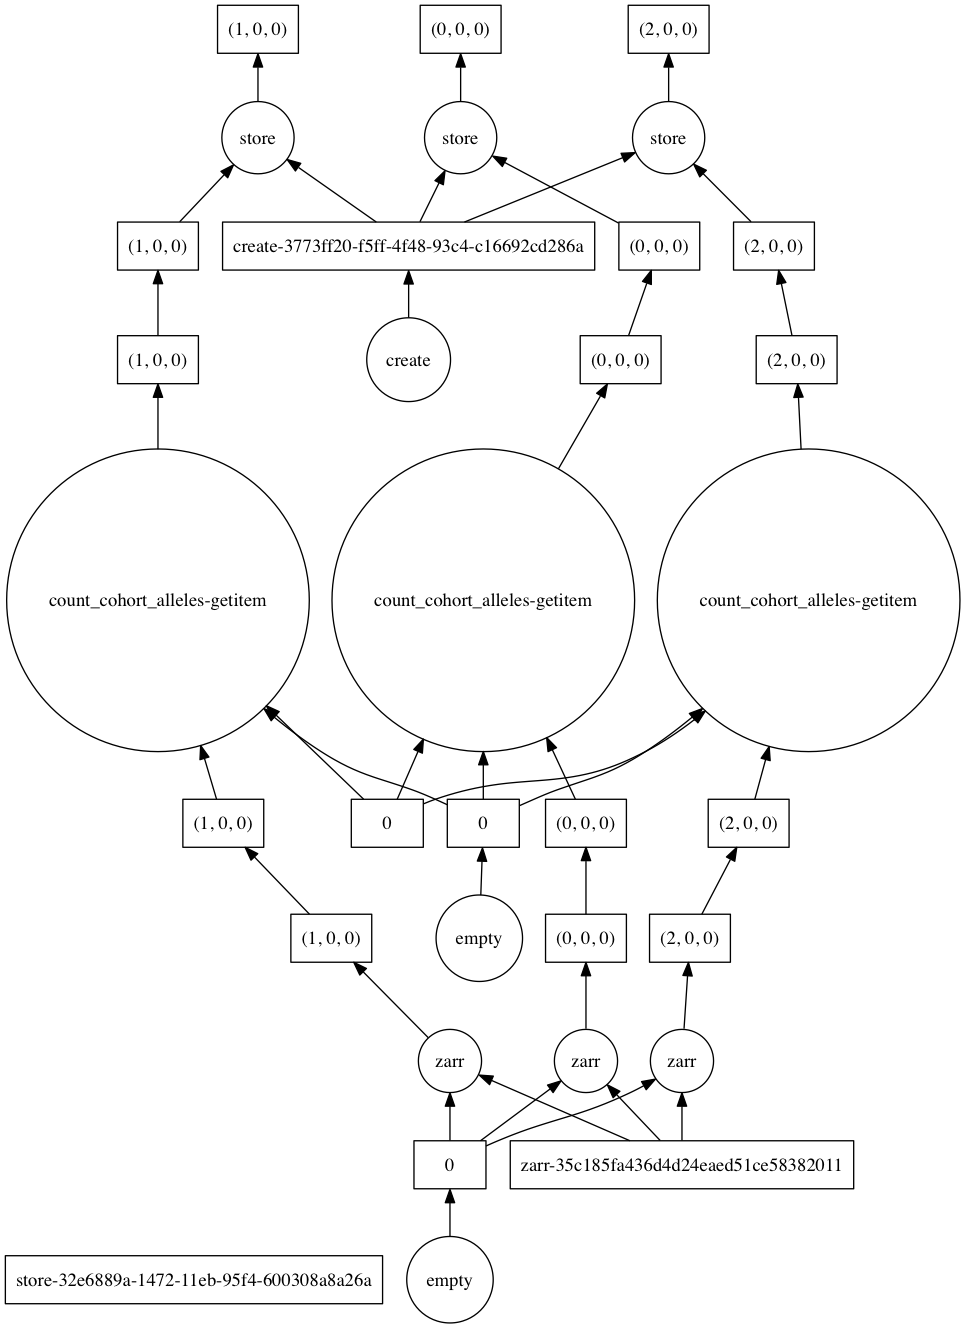

In [9]:
d.visualize(optimize_graph=True, verbose=True)

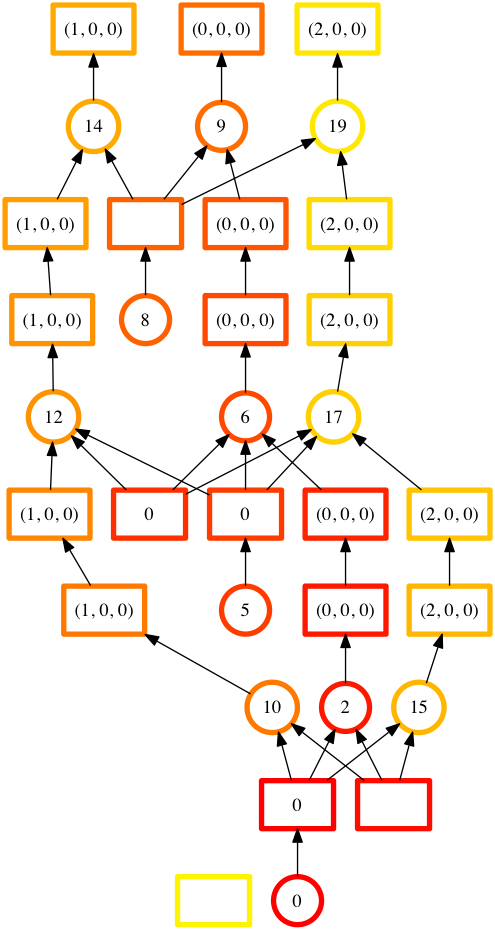

In [23]:
d.visualize(filename="order", optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})

In [11]:
ds

<xarray.Dataset>
Dimensions:             (alleles: 4, cohorts: 1, ploidy: 2, samples: 1142, variants: 57837885)
Coordinates:
  * cohorts             (cohorts) <U4 'co_0'
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(65536, 1142, 2), meta=np.ndarray>
    sample_id           (samples) <U1 dask.array<chunksize=(1142,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(65536, 4), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    sample_cohort       (samples) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    contigs:                    ['2L', '2R', '3L', '3R', 'X']
    max_variant_allele_length:  1

Calculate per-variant diversity

In [6]:
with ProgressBar():
    ds = sg.diversity(ds)

[########################################] | 100% Completed |  0.1s
[                                        ] | 1% Completed |  3min 53.2s


KeyboardInterrupt: 